# Защита данных клиентов страховой компании

**Постановка задачи:** Вам нужно защитить данные клиентов страховой компании. Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

* [1. Загрузка данных](#first_bullet)
    * [1.1. Импорт библиотек](#second_bullet)
    * [1.2. Чтение файла и изучение данных](#third_bullet)
* [2. Умножение матриц](#fourth_bullet)
* [3. Алгоритм преобразования](#fifth_bullet)
* [4. Проверка алгоритма](#sixth_bullet)
    * [4.1. Преобразования данных](#seventh_bullet)
    * [4.2. Обучение модели](#eighth_bullet)
* [5. Вывод](#ninth_bullet)

## 1. Загрузка данных<a id="first_bullet"></a>

### 1.1. Импорт библиотек<a id="second_bullet"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('muted')

from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

### 1.2. Чтение файла и изучение данных<a id="third_bullet"></a>

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [3]:
data.tail()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0
4999,1,28.0,40600.0,1,0


Методом *info* посмотрим общую информацию о датафрейме.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Можно отметить, что:

- датафрейм содержит 4 признака и 1 целевой признак (страховые выплаты клиенту за последние 5 лет)
- все признаки — количественные
- пропуски в данных отсутствуют. 

На этом этапе проекта:
- для удобства переименуем столбцы
- для признаков *age*, *family_members* и *insurance_benefits* заменим тип данных на *int*
- проверим данные на дубликаты
- визуализируем признаки и посмотрим на корреляцию между признаками. 

Переименуем столбцы:

In [5]:
data.rename(columns={'Пол': 'sex', 'Возраст': 'age', 'Зарплата': 'salary', 'Члены семьи': 'family_members', 
                     'Страховые выплаты': 'insurance_benefits'}, inplace=True)
data.sample()

,sex,age,salary,family_members,insurance_benefits
25,1,47.0,38400.0,3,1


Заменим тип данных для признаков *age*, *family_members* и *insurance_benefits*.

In [6]:
to_int = ['age', 'family_members', 'insurance_benefits']
data[to_int] = data[to_int].astype('int')

In [7]:
data[to_int].dtypes

age                   int64
family_members        int64
insurance_benefits    int64
dtype: object

Проверим данные на дубликаты.

In [8]:
data.duplicated().value_counts()

False    4847
True      153
dtype: int64

Датасет содержит дубликаты, удалим их.  

In [9]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True, drop=True)

Проверка результата. 

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 4847 non-null   int64  
 1   age                 4847 non-null   int64  
 2   salary              4847 non-null   float64
 3   family_members      4847 non-null   int64  
 4   insurance_benefits  4847 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 189.5 KB


Исследуем признаки более подробно:
- методом *describe* посмотрим общую статистическую информацию о каждом признаке
- визуализируем графики
- построим матрицу корреляций. 

In [11]:
data.describe()

,sex,age,salary,family_members,insurance_benefits
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811842,1.203425,0.152259
std,0.500049,8.487995,9972.953985,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


/home/agnese/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


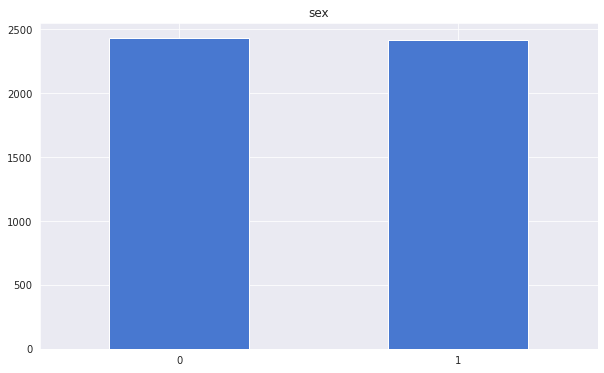

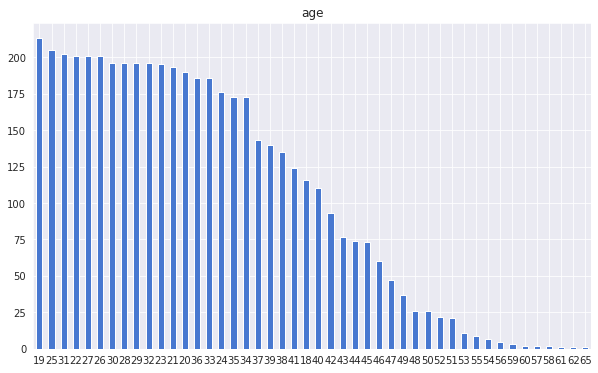

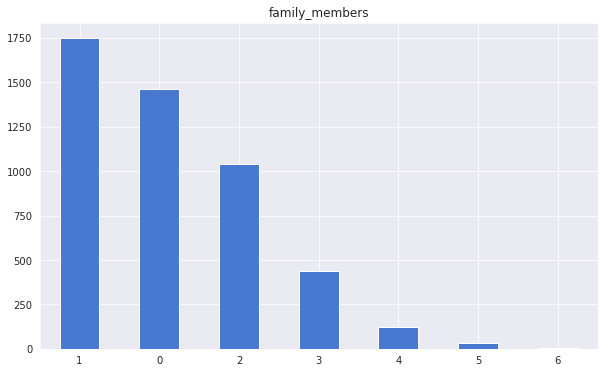

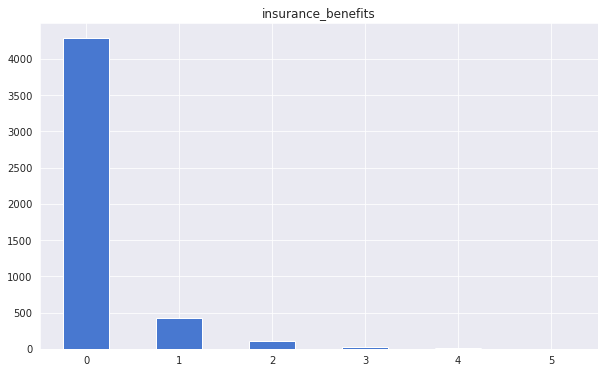

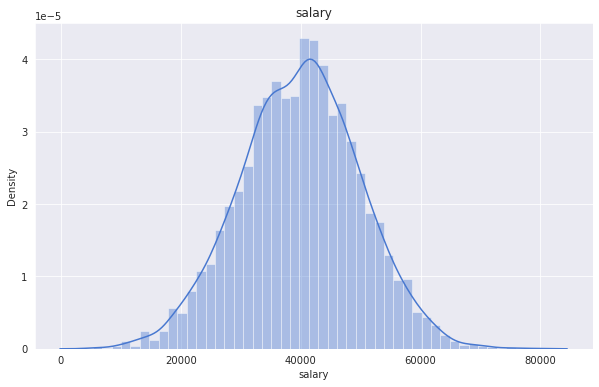

In [12]:
countplot = ['sex', 'age', 'family_members', 'insurance_benefits']
displot = ['salary']

for col in countplot:
    values = data[col].value_counts()
    plt.figure(figsize=(10,6))
    values.plot(kind = 'bar')
    plt.xticks(rotation=0)
    plt.title(col)
    
for col in displot:
    plt.figure(figsize=(10,6))
    sns.distplot(data[col])
    plt.title(col) 

- количество женщин и мужчин среди клиентов почти одинаковое
- чаще всего в страховую компанию обращаются люди в возрасте от 18 до ~42 года
- чаще всего клиенты имеют 1 член семьи, реже - 3 и больше
- наибольшая часть клиентов (~88%) за последние 5 лет не получали страховые выплаты. ~8% клиентов получили выплату один раз 
- из графика распределение зарплаты видим, что большинство значений приходится на диапазон от 35 до 45 тысяч руб. в месяц.

Посмотрим на корреляцию между признаками. 

In [13]:
correlation_map = data.corr()
correlation_map

,sex,age,salary,family_members,insurance_benefits
sex,1.000000,0.001953,0.015456,-0.007315,0.011565
age,0.001953,1.000000,-0.017386,-0.009064,0.654964
salary,0.015456,-0.017386,1.000000,-0.031687,-0.013123
family_members,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
insurance_benefits,0.011565,0.654964,-0.013123,-0.039303,1.000000


<AxesSubplot:title={'center':'Корреляция между признаками'}>

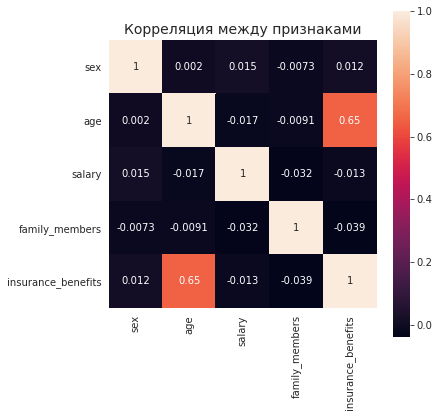

In [14]:
plt.figure(figsize = (6,6))
plt.title('Корреляция между признаками', size=14)
sns.heatmap(correlation_map, annot = True, square=True)

Можно сказать, что есть корреляция между признаком *age* и целевым признаком *insurance_benefits* (коэффициент корреляции = 0.65).

На этом этапе проекта загрузили и изучили данные:

- убедились, что данные не содержат пропуски
- обработали данные: заменили тип данных для признаков *age*, *family_members* и *insurance_benefits*, переименовали признаки
- подробно изучили каждый из признаков и выяснили, что:
    
    - количество женщин и мужчин среди клиентов страховой компании почти одинаковая
    
    - чаще всего в страховую компанию обращаются люди в возрасте от 18 до ~42 года
    - чаще всего клиенты имеют 1 член семьи, реже - 3 и больше
    - чаще всего клиенты страховой компании зарабатывают от 35 до 45 тысяч руб. в месяц
    - 88% клиентов за последние 5 лет не получали страховые выплаты. 

## 2. Умножение матриц<a id="fourth_bullet"></a>

**Задача: Ответьте на вопрос и обоснуйте решение. Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)**

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)
 
- $Е$ — единичная матрица 

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** нет, не изменится. 

**Обоснование:**

Новая матрица признаков:

$$X' = XP$$

Таким образом новый вектор весов $w'$ можем расчитать следующим образом:

$$w' = ((XP)^{T} XP)^{-1} (XP)^{T} y = \\ 
     = (P^{T}X^{T} XP)^{-1}P^{T}X^{T}y  = \\ 
     = P^{-1} (X^{T} X)^{-1} (P^{T})^{-1} P^{T}X^{T}y = \\ 
     = P^{-1} w, $$ 
     
так как внутри формулы можно выделить формулу расчета $w$, а

$$(P^{T})^{-1} P^{T} = Е = 1$$


Таким образом:

$$ a' = X'w' = XPP^{-1}w = XEw = Xw= a $$

Тут можно отметить, что, если любую матрицу Р умножить на единичную (или наоборот), получится эта же матрица Р. Т.е., матрицы будут одинаковыми, а качество линейной регрессии не изменится.

**Вывод:** Предсказания модели не изменились, значит, и качество осталось тем же.

## 3. Алгоритм преобразования<a id="fifth_bullet"></a>

**Задача: Предложите алгоритм преобразования данных для решения задачи. Обоснуйте, почему качество линейной регрессии не поменяется.**

**Алгоритм**

1) методом *make_spd_matrix* создаем случайную матрицу A

2) методом *np.linalg.inv()* проверяем матрицу А на обратимость и получаем $А^{-1}$. Если матрица А провалила тест на обратимость (вероятность этого очень маленькая), необходимо создать новую случайную матрицу. 

Поскольку нам надо закодировать данные клиентов, матрица А будет ключом кодирования. 

3) умножаем матрицу признаков X на полученную матрицу А и получаем матрицу B с закодированными данными о клиентах:

$$ B = X @ A $$

После этого можно переходить к обучению модели линейной регрессии. 


**Обоснование**

Такой алгоритм позволит защитить персональную информацию клиентов и при этом не должен повлиять на работу модели (ранее уже отмечалось, что качество модели не изменится, если матрицу признаков умножать на обратимую модель).

## 4. Проверка алгоритма<a id="sixth_bullet"></a>

### 4.1. Преобразования данных<a id="seventh_bullet"></a>

Сохраним признаки и целевой признак в отдельные переменные.

In [15]:
features = data.drop('insurance_benefits', axis=1)
target = data['insurance_benefits']

print('Признаки', features.shape)
print('Целевой признак', target.shape)

Признаки (4847, 4)
Целевой признак (4847,)


Создадим матрицу признаков. 

In [16]:
features_matrix = features.values
features_matrix

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Методом *make_spd_matrix* создадим случайную матрицу. 

In [17]:
random_matrix = make_spd_matrix(n_dim=4, random_state=123)
random_matrix

array([[ 0.47243659,  0.36201499,  0.23624413, -0.20756552],
       [ 0.36201499,  3.26723888,  1.70966795, -0.39838002],
       [ 0.23624413,  1.70966795,  1.32704651, -0.17893753],
       [-0.20756552, -0.39838002, -0.17893753,  0.35460046]])

Проверим случайную матрицу на обратимость. 

In [18]:
np.linalg.inv(random_matrix)

array([[ 2.97675307,  0.09601407, -0.43363796,  1.63149048],
       [ 0.09601407,  1.02415391, -1.2595126 ,  0.57122764],
       [-0.43363796, -1.2595126 ,  2.39108163, -0.46226306],
       [ 1.63149048,  0.57122764, -0.46226306,  4.18355526]])

Ошибки не возникло, значит матрица обратима.  

Умножим матрицу признаков *features_matrix* на матрицу *random_matrix*. Результат сохраним в переменной *encoded_matrix*. 

In [19]:
encoded_matrix = features_matrix @ random_matrix
encoded_matrix

array([[11732.81637505, 84933.45064883, 65891.66076973, -8891.48812605],
       [ 8993.72209566, 65117.27663171, 50506.23330695, -6817.59709104],
       [ 4971.62518218, 35997.77683511, 27917.55715724, -3769.24118958],
       ...,
       [ 8015.50120409, 58022.29145405, 45020.71229678, -6073.24072949],
       [ 7732.99714812, 55977.18802921, 43431.73312289, -5859.16541635],
       [ 9601.91300269, 69503.96501156, 53926.01646352, -7275.87139908]])

In [20]:
type(encoded_matrix)

numpy.ndarray

Данные преобразовали. Можно приступить к обучению модели.

### 4.2. Обучение модели<a id="eighth_bullet"></a>

#### Исходные данные

Сначала обучим модель линейной регрессии на исходных данных. 

Разделим исходные данные на 2 выборки: обучающую и валидационную. 

In [21]:
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              train_size=0.75, 
                                                                              test_size=0.25, 
                                                                              random_state=123)

Выведем на экран размер выборок.

In [22]:
print('features_train:', features_train.shape) 
print('target_train:', target_train.shape)

print('')

print('features_valid:', features_valid.shape)
print('target_valid:', target_valid.shape)

features_train: (3635, 4)
target_train: (3635,)

features_valid: (1212, 4)
target_valid: (1212,)


Обучим модель линейной регрессии и посчитаем метрику *R2*. 

In [23]:
model_raw = LinearRegression()
model_raw.fit(features_train, target_train)
predictions_raw = model_raw.predict(features_valid)
r2_raw = r2_score(target_valid, predictions_raw)

print('Метрика R2 до преобразования данных:', r2_raw)

Метрика R2 до преобразования данных: 0.40978958053663517


Метрика *R2* не равно 0 и не больше 1, значит модель работает. 

Проверим метрику на преобразованных данных. 

#### Преобразованные данные

In [24]:
features_train_encoded, features_valid_encoded, target_train_encoded, target_valid_encoded = train_test_split(
    encoded_matrix, target, train_size=0.75, test_size=0.25, random_state=123)

Выведем на экран размер выборок.

In [25]:
print('features_train_encoded:', features_train_encoded.shape) 
print('target_train_encoded:', target_train_encoded.shape)

print('')

print('features_valid_encoded:', features_valid_encoded.shape)
print('target_valid_encoded:', target_valid_encoded.shape)

features_train_encoded: (3635, 4)
target_train_encoded: (3635,)

features_valid_encoded: (1212, 4)
target_valid_encoded: (1212,)


Обучим модель линейной регрессии. 

In [26]:
model_encoded = LinearRegression()
model_encoded.fit(features_train_encoded, target_train_encoded)
predictions_encoded = model_encoded.predict(features_valid_encoded)

r2_encoded = r2_score(target_valid_encoded, predictions_encoded)
print('Метрика R2 после преобразования данных:', r2_encoded)

Метрика R2 после преобразования данных: 0.40978958053641945


Сравним результат метрики *R2* до и после преобразования данных. 

In [27]:
print('Метрика R2 до преобразования данных:', r2_raw)
print('Метрика R2 после преобразования данных:', r2_encoded)

Метрика R2 до преобразования данных: 0.40978958053663517
Метрика R2 после преобразования данных: 0.40978958053641945


Метрики почти идентичны, а это значит, что качество модели линейной регрессии после преобразования данных не изменилось. Но стотит отметить, что сам показатель метрики *R2* достаточно низкий, значит, качество модели можно значительно улучшить, например, меняя гиперпараметри. 

## 5. Вывод<a id="ninth_bullet"></a>

Во время проекта выполнили следующие шаги:
- загрузили и изучили данные
- математически доказали, что качество линейной регрессии не изменится, если умножать признаки на обратимую матрицу
- предложили алгоритм преобразования данных и протестировали его работу. Удалось доказать, что качество модели линейной регрессии после преобразования данных не изменилось. 